# CONTRACHECK 

### Import statements

In [1]:
import os
import time
import keras
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.layers import LSTM, Bidirectional
from keras.layers import Dropout
from keras.utils import plot_model
import itertools
from keras import *
from keras import backend as K
from keras.engine.topology import Layer
from keras.utils import to_categorical
from keras.callbacks import TensorBoard

Using TensorFlow backend.


### Load word embeddings (GloVe 300d)

In [2]:
EMBEDDING_DIM = 300

print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join('glove.6B', 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


### Preprocess data

In [10]:
sentences = {}
antonyms = {}
finallist = []

def IOU(sentenceA,sentenceB):
      s = set(sentenceA.lower().split())
      t = set(sentenceB.lower().split())
      Union = s|t
      Intersection = s&t
      return float(len(Intersection)/len(Union))
      
def Negation(sentenceA,sentenceB) :
      Words = ["no","never", "no one","nothing" ,"not","without","nobody"]
      s = set(sentenceA.lower().split())
      t = set(sentenceB.lower().split())
      Union = s|t
      Intersection = s&t
      
      for j in Words:
         if j in Union and j not in Intersection :
            return 1.0
            
      return 0.0

def Overlap(sentenceA,sentenceB):
      s = set(sentenceA.lower().split())
      t = set(sentenceB.lower().split())

      return float(len(s&t)/min(len(sentenceA),len(sentenceB)))   

def loadDataset(filename):
      inputfile = open(filename)
      for line in inputfile:
            s = line.replace('\n', '').replace(',','').replace('\'','').replace(".",'').replace("?",'').replace("!",'').lower().split('\t')
            sentences[line] = [s[1],s[2],s[4]]

def loadAntonyms(filename):
      inputfile = open(filename)
      for line in inputfile:
            s = line.lower().split('\t')
            x = s[1].replace(' ','').replace('\n','').split(",")
            # if(s[1] == '' or s[0] == ''):
            #       print(s[0],s[1])
            antonyms[s[0]] = x

def antonymCheck(sentenceA,sentenceB):
      s1_list = []
      s2_list = []
      s1_list = sentenceA.lower().split()
      s2_list = sentenceB.lower().split()

      for s in s1_list:
            if s in antonyms:
                  for x in s2_list:
                        for w in antonyms[s]:
                              if w == x:
                                    return 1
      return 0

loadDataset("testcases.txt")
loadAntonyms("antonyms.txt")

In [120]:
texts = []
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids

sentences = []

sentenceA = []
sentenceB = []
classLabel = []
iou = []
negation = []
antonym = []
overlapcoeff = []


with open('phemeTraining.txt') as f:
	for line in f:
		sentence = line.replace('\'','').lower().split('\t') #replace('\n', '').
		sentences.append(sentence)

with open('phemeTesting.txt') as f:
	for line in f:
		sentence = line.replace('\'','').lower().split('\t')
		sentences.append(sentence)

print(len(sentences))
print(sentences[0])

for line in sentences:
	#print(line)
    if line[1] != 'yes':
        sentenceA.append(line[3])
        texts.append(line[3])
        sentenceB.append(line[4])
        texts.append(line[4])
        label = line[1]
        if label == 'contradiction':
            classLabel.append("CONTRADICTION")
        elif label == 'unknown':
            classLabel.append("NEUTRAL")
        else:
            print(line[3])
        
        text1 = line[3].replace(',','').replace('\'','').replace(".",'').replace("?",'').replace('-',' ').replace("!",'').lower()
        text2 = line[4].replace(',','').replace('\'','').replace(".",'').replace("?",'').replace('-',' ').replace("!",'').lower()
        iou.append(IOU(text1,text2))
        negation.append(Negation(text1,text2))
        antonym.append(antonymCheck(text1, text2))
        overlapcoeff.append(Overlap(text1, text2))

print("total sentences: ", len(sentences))        
print(len(sentenceA), len(sentenceB), len(classLabel))

print(len(iou), len(negation), len(antonym), len(overlapcoeff))

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=400000)
tokenizer.fit_on_texts(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

embeddedVecA = []
embeddedVecB = []
for sen in sentenceA:
	emb = []
	for word in sen.split():
		if word_index.get(word) is not None:
			emb.append(word_index.get(word))
		else:
			emb.append(0)
	embeddedVecA.append(emb)

for sen in sentenceB:
	emb = []
	for word in sen.split():
		if word_index.get(word) is not None:
			emb.append(word_index.get(word))
		else:
			emb.append(0)
	embeddedVecB.append(emb)

encoder = LabelEncoder()
encoder.fit(classLabel)
encoded_Y = encoder.transform(classLabel)
onehot = np.array(np_utils.to_categorical(encoded_Y))

vectorA = pad_sequences(embeddedVecA, maxlen=40, padding='post')
vectorB = pad_sequences(embeddedVecB, maxlen=40, padding='post')

1293
['553555600911925249.json_553096753898323968.json', 'contradiction', 'story 1: there is a gunman/has been a shooting incident in trocadero (police clearing the area); story 2: shots were fired at montrouge in paris', 'french media report the trocadero near the eiffel tower in paris has been evacuated and police have been deployed there', '"breaking: automatic gunfire reported at montrouge near paris. gunmen escaped in metro, say french reports "\n']
total sentences:  1293
1293 1293 1293
1293 1293 1293 1293
Found 589 unique tokens.


In [121]:
print(classLabel.count("CONTRADICTION"))
print(classLabel.count("NEUTRAL"))

427
866


### Split data to test-train sets

In [122]:
vecAtrain = vectorA[:906]
vecBtrain = vectorB[:906]
y_train = onehot[:906]

print("vecAtrain", vecAtrain.shape)
print("vecBtrain", vecBtrain.shape)
print("y_train", y_train.shape)

vecAtest = vectorA[906:]
vecBtest = vectorB[906:]
y_test = onehot[906:]

print("vecAtest", vecAtest.shape)
print("vecBtest", vecBtest.shape)
print("y_test", y_test.shape)

iou = np.array(iou)
negation = np.array(negation)
antonym = np.array(antonym)
overlapcoeff = np.array(overlapcoeff)

iou_train = iou[:906]
negation_train = negation[:906]
antonym_train = antonym[:906]
overlapcoeff_train = overlapcoeff[:906]

iou_test = iou[906:]
negation_test = negation[906:]
antonym_test = antonym[906:]
overlapcoeff_test = overlapcoeff[906:]

print("iou shape", iou.shape)
print("negation shape", negation.shape)
print("antonym shape", antonym.shape)
print("overlapcoeff shape", antonym.shape)

vecAtrain (906, 40)
vecBtrain (906, 40)
y_train (906, 2)
vecAtest (387, 40)
vecBtest (387, 40)
y_test (387, 2)
iou shape (1293,)
negation shape (1293,)
antonym shape (1293,)
overlapcoeff shape (1293,)


### Prepare embedding layer

In [123]:
print('Preparing embedding matrix.')

print("word_index",len(word_index))
num_words = 400000
embedding_matrix = np.zeros((400001, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=40, trainable=False)
print("done!")

Preparing embedding matrix.
word_index 589
done!


### Network architecture

In [124]:
### Model without automated feature
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

ioou = Input(shape=(1,), dtype='float32', name='iou')
negate = Input(shape=(1,), dtype='float32', name='negate')
antonym = Input(shape=(1,), dtype='float32', name='antonym')
overlap = Input(shape=(1,), dtype='float32', name='overlap')
mix = keras.layers.concatenate([ioou, negate, antonym, overlap], axis=-1)
mix = Dense(5, activation ='relu', kernel_initializer='he_normal')(mix)
main_output = Dense(2, activation='softmax')(mix)

model = Model(inputs=[ioou, negate, antonym, overlap], outputs=[main_output])
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
#tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1,embeddings_freq = 1,embeddings_layer_names = None, write_graph=True, write_images=False)
# plot_model(model, to_file='model2_final.png')
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
model.summary()
history = model.fit(x =[iou_train, negation_train, antonym_train, overlapcoeff_train], y = [y_train], validation_data=([iou_test, negation_test, antonym_test, overlapcoeff_test], y_test),verbose=1, epochs=30, batch_size=64, callbacks=[early_stopping_monitor, reduce_lr]) #, callbacks=[tensorboard]
model.save('final_FC_model_Semeval.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
iou (InputLayer)                (None, 1)            0                                            
__________________________________________________________________________________________________
negate (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
antonym (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
overlap (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenat

In [136]:
### LSTM Model

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

senA = Input(shape=(40,), dtype='int32', name='senA')
emb_x = embedding_layer(senA)
print("emb_x: ", emb_x)
senB = Input(shape=(40,), dtype='int32', name='senB')
emb_y = embedding_layer(senB)   
print("emb_y: ", emb_y)

shared_lstm = Bidirectional(LSTM(64, activation = 'tanh')) #return_sequences=True,
x = shared_lstm(emb_x)
#x = AttentionWithContext()(x)
y = shared_lstm(emb_y)
#y = AttentionWithContext()(y)

# mix = keras.layers.Dot([x,y], axes=1, normalize=True)
mix = keras.layers.Subtract()([x, y]) # #, axis=-1
#x = AttentionWithContext()(mix)
x = Dense(8, activation='relu', kernel_initializer='he_normal')(mix)
x = Dropout(0.5)(x)
out = Dense(2, activation ='softmax', kernel_initializer='he_normal')(x)
model = Model(inputs=[senA, senB], outputs=[out])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
#tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1,embeddings_freq = 1,embeddings_layer_names = None, write_graph=True, write_images=False)
# plot_model(model, to_file='model2_final.png')
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=1, verbose=5, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)
history = model.fit(x =[vecAtrain, vecBtrain], y = [y_train], validation_data=([vecAtest, vecBtest], y_test),verbose=1, epochs=30, batch_size=64, callbacks=[early_stopping_monitor, reduce_lr]) #, callbacks=[tensorboard]
model.save('semeval_auto_model.h5')


emb_x:  Tensor("embedding_2/Gather:0", shape=(?, 40, 300), dtype=float32)
emb_y:  Tensor("embedding_2_1/Gather:0", shape=(?, 40, 300), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
senA (InputLayer)               (None, 40)           0                                            
__________________________________________________________________________________________________
senB (InputLayer)               (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 300)      120000300   senA[0][0]                       
                                                                 senB[0][0]                       
__________________________________________________________

In [147]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

senA = Input(shape=(40,), dtype='int32', name='senA')
emb_x = embedding_layer(senA)
print("emb_x: ", emb_x)
senB = Input(shape=(40,), dtype='int32', name='senB')
emb_y = embedding_layer(senB)   
print("emb_y: ", emb_y)

shared_lstm = Bidirectional(LSTM(64, activation = 'tanh')) #return_sequences=True,
x = shared_lstm(emb_x)
# x = AttentionWithContext()(x)
y = shared_lstm(emb_y)
# y = AttentionWithContext()(y)

# mix = keras.layers.Dot([x,y], axes=1, normalize=True)
mix = keras.layers.Subtract()([x, y]) #, axis=-1
# x = AttentionWithContext()(mix)
x = Dense(8, activation='relu', kernel_initializer='he_normal')(mix)
x = Dropout(0.5)(x)
x = Dense(1, activation ='tanh', kernel_initializer='he_normal')(x)
ioou = Input(shape=(1,), dtype='float32', name='iou')
negate = Input(shape=(1,), dtype='float32', name='negate')
antonym = Input(shape=(1,), dtype='float32', name='antonym')
overlap = Input(shape=(1,), dtype='float32', name='overlap')
mix = keras.layers.concatenate([x, ioou, negate, antonym, overlap], axis=-1)
mix = Dense(5, activation ='relu', kernel_initializer='he_normal')(mix)
main_output = Dense(2, activation='softmax')(mix)

model = Model(inputs=[senA, senB, ioou, negate, antonym, overlap], outputs=[main_output])
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
#tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1,embeddings_freq = 1,embeddings_layer_names = None, write_graph=True, write_images=False)
# plot_model(model, to_file='model2_final.png')
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
history = model.fit(x =[vecAtrain, vecBtrain, iou_train, negation_train, antonym_train, overlapcoeff_train], y = [y_train], validation_data=([vecAtest, vecBtest, iou_test, negation_test, antonym_test, overlapcoeff_test], y_test),verbose=1, epochs=30, batch_size=64, callbacks=[early_stopping_monitor, reduce_lr]) #, callbacks=[tensorboard]
model.save('final_pheme_model.h5')
#model.load_weights("final_bilstm_model.h5")

emb_x:  Tensor("embedding_2_2/Gather:0", shape=(?, 40, 300), dtype=float32)
emb_y:  Tensor("embedding_2_3/Gather:0", shape=(?, 40, 300), dtype=float32)
Train on 906 samples, validate on 387 samples
Epoch 1/30
906/906 [==============================] - 18s - loss: 0.6772 - acc: 0.6987 - val_loss: 0.6424 - val_acc: 0.6718
Epoch 2/30
906/906 [==============================] - 5s - loss: 0.6213 - acc: 0.6689 - val_loss: 0.5757 - val_acc: 0.6718
Epoch 3/30
906/906 [==============================] - 5s - loss: 0.5621 - acc: 0.6689 - val_loss: 0.5070 - val_acc: 0.6718
Epoch 4/30
906/906 [==============================] - 5s - loss: 0.4998 - acc: 0.6689 - val_loss: 0.4543 - val_acc: 0.6718
Epoch 5/30
906/906 [==============================] - 5s - loss: 0.4539 - acc: 0.6689 - val_loss: 0.4144 - val_acc: 0.6718
Epoch 6/30
906/906 [==============================] - 5s - loss: 0.4178 - acc: 0.6689 - val_loss: 0.3838 - val_acc: 0.6718
Epoch 7/30
906/906 [==============================] - 5s - loss

### Model summary

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
senA (InputLayer)               (None, 40)           0                                            
__________________________________________________________________________________________________
senB (InputLayer)               (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 300)      120000300   senA[0][0]                       
                                                                 senB[0][0]                       
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128)          186880      embedding_1[0][0]                
          

### Model architecture illustration (ENSEMBLE)

![title](final_arch.png)

### Histogram of y-hat

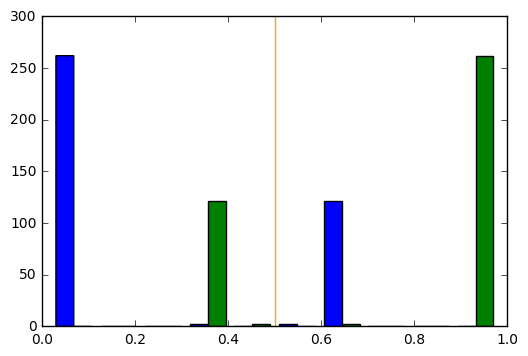

In [149]:
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt

y_hat = model.predict([vecAtest, vecBtest, iou_test, negation_test, antonym_test, overlapcoeff_test]) # 
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')
plt.show()

In [150]:
"ROC Score: "+"{:0.2f}".format(roc_auc_score(y_test, y_hat)*100.0)

'ROC Score: 99.59'

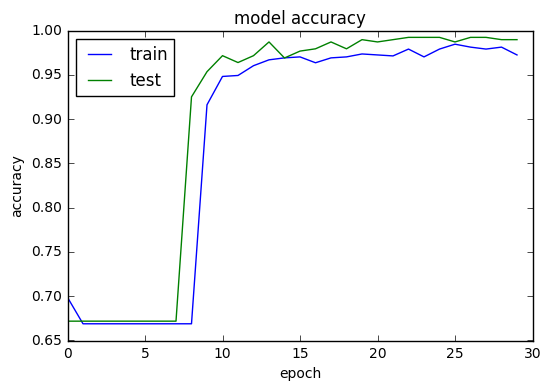

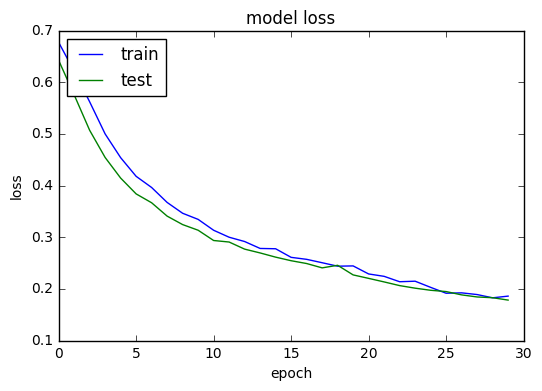

In [151]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Confusion matrix

In [152]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Total number of contradictions:  127
Total number of non_contradictions:  260
Confusion matrix, without normalization
[[123   4]
 [  0 260]]
Normalized confusion matrix
[[ 0.9685  0.0315]
 [ 0.      1.    ]]


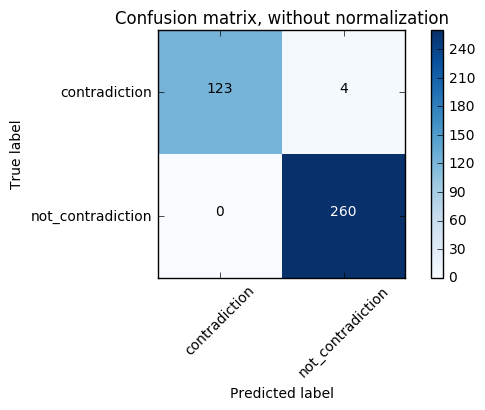

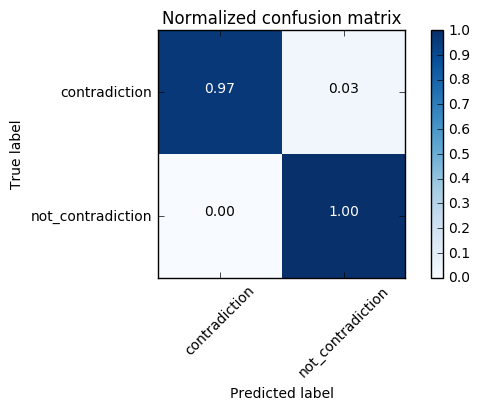

In [153]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = ['contradiction', 'not_contradiction']

# Compute confusion matrix
b = np.zeros_like(y_hat)
b[np.arange(len(y_hat)), y_hat.argmax(1)] = 1
b = b.astype(int)
y_test = y_test.astype(int)

y_true = []
y_pred = []

for l in y_test:
    if l[0] == 1:
        y_true.append("contradiction")
    else:
        y_true.append("not_contradiction")

for l in b:
    if l[0] == 1:
        y_pred.append("contradiction")
    else:
        y_pred.append("not_contradiction")
        

print("Total number of contradictions: ", y_true.count("contradiction"))
print("Total number of non_contradictions: ", y_true.count("not_contradiction"))

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Scoring metrics (Precision, Recall, F1-score)

In [154]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

In [155]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("F1-score: ", fscore)
print("Precision: ", precision)
print("recall: ", recall)
#print("F1-score for contradiction and non-contradiction: ", f1_score(y_true, y_pred, average=None))
print("ROC AUC for contradiction, not_contradiction: ", roc_auc_score(y_test, y_hat, average=None))

F1-score:  0.989620845415
Precision:  0.989820687495
recall:  0.989664082687
ROC AUC for contradiction, not_contradiction:  [ 0.9959  0.9959]


### Contradiction accuracy

In [17]:
print("Contradiction accuracy: ", 593/720)

Contradiction accuracy:  0.8236111111111111


# State of the art results

![title](state_of_the_art.jpg)

### In contradiction class, our system beats the current state of the art by a 0.28 margin

# Naive Bayes performance on same dataset

![title](nb.jpg)

### Our system beats naive bayes in every evaluation metric!

In [18]:
index2word = {v: k for k, v in word_index.items()}

# classify new pairs of sentences

### hand engineered features 

In [29]:
sentences = {}
antonyms = {}
finallist = []

def IOU(sentenceA,sentenceB):
      s = set(sentenceA.lower().split())
      t = set(sentenceB.lower().split())
      Union = s|t
      Intersection = s&t
      return float(len(Intersection)/len(Union))
      
def Negation(sentenceA,sentenceB) :
      Words = ["no","never", "no one","nothing" ,"not","without","nobody"]
      s = set(sentenceA.lower().split())
      t = set(sentenceB.lower().split())
      Union = s|t
      Intersection = s&t
      
      for j in Words:
         if j in Union and j not in Intersection :
            return 1
            
      return 0

def Overlap(sentenceA,sentenceB):
      s = set(sentenceA.lower().split())
      t = set(sentenceB.lower().split())

      return float(len(s&t)/min(len(sentenceA),len(sentenceB)))   

def loadDataset(filename):
      inputfile = open(filename)
      for line in inputfile:
            s = line.replace('\n', '').replace(',','').replace('\'','').replace(".",'').replace("?",'').replace("!",'').lower().split('\t')
            sentences[line] = [s[1],s[2],s[4]]

def loadAntonyms(filename):
      inputfile = open(filename)
      for line in inputfile:
            s = line.lower().split('\t')
            x = s[1].replace(' ','').replace('\n','').split(",")
            # if(s[1] == '' or s[0] == ''):
            #       print(s[0],s[1])
            antonyms[s[0]] = x

def antonymCheck(sentenceA,sentenceB):
      s1_list = []
      s2_list = []
      s1_list = sentenceA.lower().split()
      s2_list = sentenceB.lower().split()

      for s in s1_list:
            if s in antonyms:
                  for x in s2_list:
                        for w in antonyms[s]:
                              if w == x:
                                    return 1
      return 0

loadDataset("testcases.txt")
loadAntonyms("antonyms.txt")

In [ ]:
while(True):

	text1 = input("Type sentence A: ").replace(',','').replace('\'','').replace(".",'').replace("?",'').replace("!",'').lower()
	text2 = input("Type sentence B: ").replace(',','').replace('\'','').replace(".",'').replace("?",'').replace("!",'').lower()
	iou = []
	iou.append(IOU(text1,text2))
	negation = []
	negation.append(Negation(text1,text2))
	overlap = []
	overlap.append(Overlap(text1,text2))
	antonym = []
	antonym.append(antonymCheck(text1,text2))

	iou = np.array(iou)
	negation = np.array(negation)
	overlap = np.array(overlap)
	antonym = np.array(antonym)

	texts = []
	texts.append(text1.split())
	texts.append(text2.split())
	embeddedVec = [] #tokenizer.texts_to_sequences(texts)

	for sen in texts:
		emb = []
		print(sen)
		for word in sen:
			if word_index.get(word) is not None:
				emb.append(word_index.get(word))
			else:
				emb.append(0)
		embeddedVec.append(emb)

	print("Embeddings", embeddedVec)
	vectors = pad_sequences(embeddedVec, maxlen=40, padding='post')

	print(vectors, iou, negate, antonym, overlap)
    
# 	exit(0)
	vecA = vectors[0].reshape(1,40)
	vecB = vectors[1].reshape(1,40)
	iou = iou.reshape(1,1)
	negation = negation.reshape(1,1)
	overlap = overlap.reshape(1,1)
	antonym = antonym.reshape(1,1)

	#inp = np.array([vecA, vecB, iou, negation, antonym, overlap])
	# inp = inp.reshape(6,1)
	#print(inp.shape)
	result = model.predict([vecA, vecB, iou, negation, antonym, overlap])
	# print(result)
	index = np.argmax(result)

	if index == 0:
		print("CONTRADICTION")
		print("Confidence: ", result[0][0]*100, "%")
	if index == 1:
		print("NOT CONTRADICTION")
		print("Confidence: ", result[0][1]*100, "%")

In [156]:
results = model.predict([vecAtest, vecBtest, iou_test, negation_test, antonym_test, overlapcoeff_test]) #

In [57]:
print(sentenceA[3822])
print(sentenceB[3822])
print(vecAtest[0], vecBtest[0])
print(results[0])
print(y_test[0])

there is no boy playing outdoors and there is no man smiling
a group of kids is playing in a yard and an old man is standing in the background
[ 15   2  14  22  12 185   6  15   2  14   4 208   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0] [  1  66  10 123   2  12   5   1 247   6  23 251   4   2  18   5   3 204
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
[ 0.2666  0.7334]
[0 1]


In [157]:
check = 0
for i in range(len(results)):
    if y_test[i][0] == 1:
        if results[i].argmax() == 1:
            check += 1
            print(sentenceA[906+i], "\t", sentenceB[906+i], "\t", )

print(check)

"breaking: automatic gunfire reported at montrouge near paris. gunmen escaped in metro, say french reports " 	 another shooting reported at the trocadero near the eiffel tower (live updates) 
 	
and now reports of a possible fourth shooting incident at trocadero near eiffel tower. trying to get confirmation. 	 "breaking: automatic gunfire reported at montrouge near paris. gunmen escaped in metro, say french reports "
 	
police officer at scene of paris hostage situation tells the bbc two people are confirmed to have died  	 "more: france: shooting, hostage-taking at kosher market in paris, several reported wounded: "
 	
police officer at scene of paris hostage situation tells the bbc two people are confirmed to have died  	 "breaking: one person seriously wounded, six taken hostage in incident at kosher supermarket in paris: police source"
 	
4
